# AXA case - Adam Wilczyński

## 1. Wstęp

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# Ważony Gini przepisany na Python. Trochę zmieniłem argumenty
def weightedGini(df):
    df = df.sort_values(by='Prediction')
    df.reset_index(inplace=True)
    df['random'] = (df['Exposure']/sum(df['Exposure'])).cumsum()
    totalPositive = sum(df['ClaimNb']*df['Exposure'])
    df['cumPosFound'] = (df['ClaimNb']*df['Exposure']).cumsum()
    df['Lorenz'] = df['cumPosFound'] / totalPositive
    n = len(df)-1
    A = np.array(df['Lorenz'].drop(0))
    B = np.array(df['random'].drop(n))
    C = np.array(df['Lorenz'].drop(n))
    D = np.array(df['random'].drop(0))
    gini = sum(A*B) - sum(C*D)
    return gini

In [3]:
# Import danych
os.chdir('C:/Users/adamw/Desktop/AXA case/MTPLfreq')
df = pd.read_csv('MTPLfreq.csv')
df.set_index('PolicyID', inplace = True)
pd.options.display.float_format = '{:,.2f}'.format

## 2. Przegląd danych i wstępne wnioski

### 2.1 zmienne ilościowe

In [8]:
df.describe()

,ClaimNb,Exposure,CarAge,DriverAge,Density
count,"413,169.00","413,169.00","413,169.00","413,169.00","413,169.00"
mean,0.04,0.56,7.53,45.32,"1,985.15"
std,0.20,0.37,5.76,14.33,"4,776.25"
min,0.00,0.00,0.00,18.00,2.00
25%,0.00,0.20,3.00,34.00,67.00
50%,0.00,0.54,7.00,44.00,287.00
75%,0.00,1.00,12.00,54.00,"1,410.00"
max,4.00,1.99,100.00,99.00,"27,000.00"


Pierwszą pozytywną obserwacją było dla mnie to, że nie ma brakujących danych, więc nie będzie problemu z uzupełnianiem braków. Nie ma również obserwacji, które w sposób ewidentny są nieprawdziwe. Wiek kierowny od 18 do 99, wydaje się być rozsądny. 99cio latek za kierownicą wydaje się być czymś mało prawdopodobnym ale realnym. Wiek samochodu również akceptuję jako poprawny. Gęstość zaludnienia w Paryżu to 21 288 os./km² (dane z Wikipedii), więc maksymalne zagęszczenie według danych (27k os./km²) również jest w granicach rozsądku.
Wydaje się, że dane są dobrej jakości, więc nie będę przeprowadzał procesu czyszczenia danych z outliersów i jak wcześniej wspomniałem nie ma potrzeby uzupełniania wybrakowanych danych.

#### 2.1.1 Gęstość zaludnienia

(0, 8000)

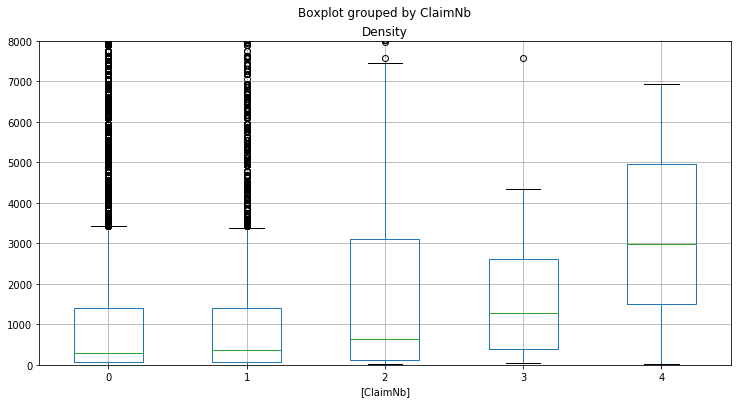

In [17]:
df[['Density','ClaimNb']].boxplot(by='ClaimNb', figsize = (12,6)).set_ylim(0,8000)

Powyższy wykres wskazuje na istotną pozytywną zależność ilości zgłoszonych incydentów od gęstości zaludnienia. <br>
-ilość zgłoszeń: oś X <br>
-gęstość zaludnienia: oś Y 

Rozkład gęstości zaludnienia dla obserwacji bez zgłoszenia lub z jednym zgłoszeniem jest niemal identyczny. Mediana jest około 300, górny kwartyk około 1400, czyli bardzo podobnie do ogólnego rozkładu gęstości zaludnienia. 

Jednakże obserwacje z dwoma lub więcej zgłoszeniami charakteryzują się znacznie większą gęstością zaludnienia w okolicy. Potwierdza to również poniższa tabelka. Ewidentnie mediana gęstości zaludnienia rośnie wraz ze wzrostem liczby incydentów. Oznacza to, że gęstość zaludnienia będzie bardzo ważną zmienną w modelu.

In [21]:
df[['ClaimNb', 'Density']].groupby(by="ClaimNb").quantile(0.5)

0.5,Density
ClaimNb,
0,287.00
1,354.00
2,640.00
3,"1,268.50"
4,"2,983.00"


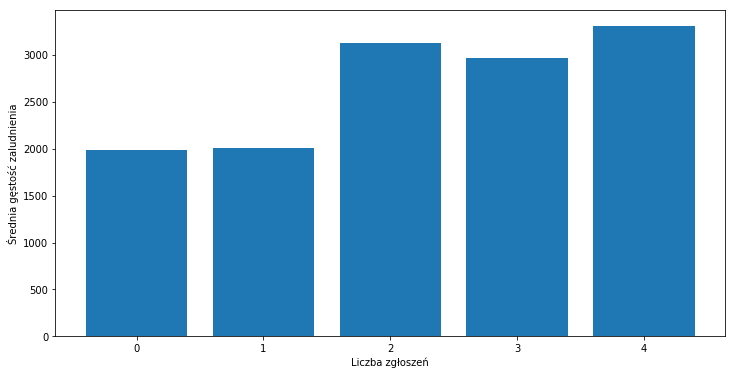

In [87]:
group_dens = df.groupby(by='ClaimNb')["Density"].mean()
data2 = pd.DataFrame(group_dens)
data2['ClaimNb'] = data2.index.values
plt.bar(x = 'ClaimNb',height = "Density", data=data2)
plt.rcParams["figure.figsize"] = [12,6]
plt.xlabel("Liczba zgłoszeń")
plt.ylabel("Średnia gęstość zaludnienia")
plt.show()

#### 2.1.2 Wiek samochodu

(0, 26)

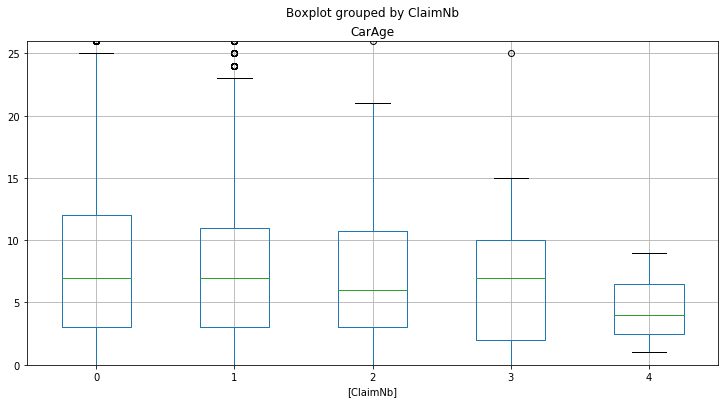

In [23]:
df[['CarAge','ClaimNb']].boxplot(by='ClaimNb', figsize = (12,6)).set_ylim(0,26) 

Wpływ wieku samochodu na liczbę zgłoszeń nie jest tak oczywisty jak wpływ gęstości zaludnienia. Widać jednak, że samochody z większą liczbą zgłoszeń są przeważnie młodsze. Na tym etapie nie jestem w pełni przekonany, czy zależność jest istotna statystycznie. Rozkłady liczby zgłoszeń od zera do trzech są podobne. Wyróżnia się rozkład dla 4 zgłoszeń. Gdy będę tworzył splajny, na pewno zwrócę uwagę na to, czy przedziały zawierające samochody poniżej 5 lat będą istotne statystycznie.

#### 2.1.3 Wiek kierowcy

(16, 90)

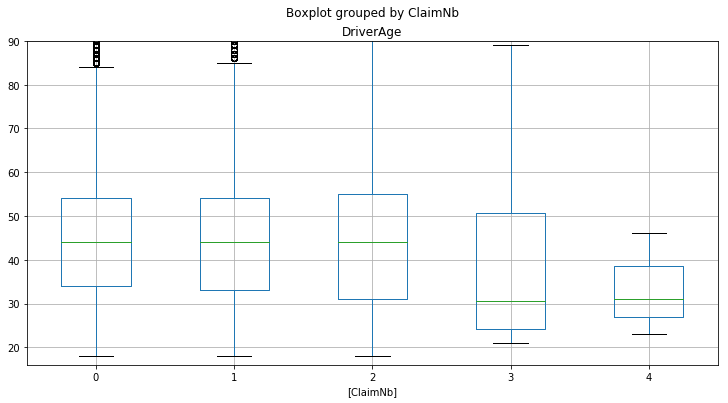

In [27]:
df[['DriverAge','ClaimNb']].boxplot(by='ClaimNb', figsize = (12,6)).set_ylim(16,90)

Wiek kierowcy będzie zdecydowanie ważną zmienną. Kierowny w przedziale od 25 do 33 lat, mogą charakteryzować się większą liczbą zgłoszeń. Ciekawe jest to, że dla trzech i czterech zgłoszeń, mediana (i górny kwartyl) jest znacznie niższa, w przeciwieństwie do dolnego kwartyla, który się podniósł. Może to świadczyć, że najmłodsi kierowcy (18-23), zgłaszają mniej incydentów. Może dlatego, że mniej jeżdżą samochodem? W każdym razie wygląda na to, że wiek kierowcy nie wpływa na ilość zgłoszeń liniowo, więc w tym przypadku splajny się bardzo przydadzą.

### 2.1.4 Korelacje zmiennych ilościowych

In [98]:
corr = df.drop('ClaimNb', axis=1).corr()
corr

,Exposure,CarAge,DriverAge,Density
Exposure,1.00,0.14,0.19,-0.11
CarAge,0.14,1.00,-0.05,-0.14
DriverAge,0.19,-0.05,1.00,-0.00
Density,-0.11,-0.14,-0.00,1.00


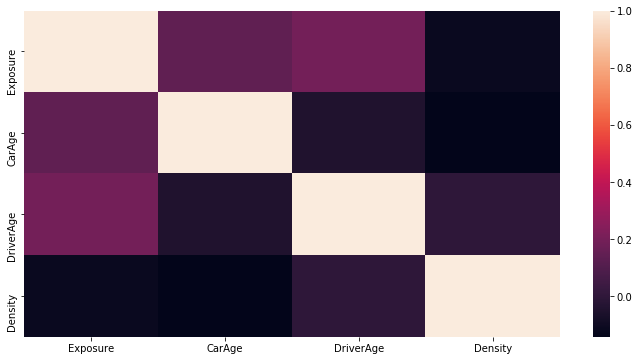

In [99]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

Korelacje zmiennych ilościowych są bardzo niewielkie. Oznacza to, że komputer nie powinien mieć problemu z odwracaniem macierzy. Najsilniejsza jest korelacja "Exposure" z "DriverAge" i "CarAge". Może starsi kierowcy preferują dłuższe okresy polisy? W każdym razie nie będzie to miało żadnego wpływu na model, gdyż "Exposure" będzie wykorzystana jako waga obserwacji.

### 2.2 zmienne nominalne

#### 2.2.1 moc

In [64]:
pd.options.display.float_format = '{:,.4f}'.format
pd.DataFrame(df.groupby(by='Power')['ClaimNb'].mean().sort_values())

,ClaimNb
Power,
l,0.0346
d,0.0347
o,0.0358
h,0.0375
g,0.0380
j,0.0394
k,0.0398
i,0.0410
m,0.0415


Różnice w średniej liczbie zgłoszeń samochodów o różnej mocy wydają się być trudne do zauważenia. Dodatkowo nie wiem, jak należałoby uporządkowac kategorie. Która kategoria ma największą moc, która najmniejszą? Prawdopodobnie moc silnika nie będzie znaczącą zmienną w moim modelu. Może za wyjątkiem skrajnych kategorii (l,d oraz f,n). Dziwne jest to, że litery "l" i "n" w alfabecie są oddalone od siebie o 2 miejsca, co sugeruje, że nie ma dużej różnicy między wartościami, a te dwie kategorie są na dwóch krańcach skali. 

#### 2.2.2 Marka samochodu

In [65]:
pd.DataFrame(df.groupby(by="Brand")['ClaimNb'].mean().sort_values())

,ClaimNb
Brand,
Japanese (except Nissan) or Korean,0.0263
"Renault, Nissan or Citroen",0.0410
other,0.0419
Fiat,0.0427
"Mercedes, Chrysler or BMW",0.0432
"Volkswagen, Audi, Skoda or Seat",0.0450
"Opel, General Motors or Ford",0.0463


Marka samochodu lepiej różnicuje liczbę zgłoszeń niż moc. Szczególnie warte uwagi są samochody japońskie i koreańskie, które zdecydowanie się wyróżniają niską liczbą zgłoszeń. Efekt niskiej awaryjności (?).

In [248]:
# Na tym etapie mogę zmienić etykiety marek samochodów, żeby zgadzały się z tym, co jest w  i zajmowały mniej miejsca.
df.loc[df.Brand=='Renault, Nissan or Citroen', 'Brand'] = 'A'
df.loc[df.Brand=='Volkswagen, Audi, Skoda or Seat', 'Brand'] = 'B'
df.loc[df.Brand=='Opel, General Motors or Ford', 'Brand'] = 'C'
df.loc[df.Brand=='Fiat', 'Brand'] = 'D'
df.loc[df.Brand=='Mercedes, Chrysler or BMW', 'Brand'] = 'E'
df.loc[df.Brand=='Japanese (except Nissan) or Korean', 'Brand'] = 'F'
df.loc[df.Brand=='other', 'Brand'] = 'G'

#### 2.2.3 Paliwo

In [66]:
df.groupby(by="Gas")['ClaimNb', 'CarAge'].mean().sort_values(by="ClaimNb")

,ClaimNb,CarAge
Gas,,
Regular,0.0373,8.3103
Diesel,0.0410,6.7497


Paliwo samochodu całkiem dobrze różnicuje liczbę zgłoszeń. Diesel zwiększa ryzyko incydentu. Zastanawiałem się, czy będzie autokorelacja rodzaju paliwa z wiekiem samochodu, gdyż wydaje mi się, że diesel jest bardziej popularny wśród starszych samochodów. Dane jednak wskazują, że średnia wieku Diesela to 6.7 a normalnego paliwa 8.3, co raczej przeczy mojej hipotezie. 

#### 2.2.4 Region

In [67]:
pd.DataFrame(df.groupby(by='Region')['ClaimNb', 'Density'].mean().sort_values(by='ClaimNb'))

,ClaimNb,Density
Region,,
R23,0.0250,"1,629.0314"
R72,0.0337,"1,201.9765"
R31,0.0346,"1,589.2316"
R11,0.0371,"8,085.6901"
R24,0.0403,461.4377
R52,0.0407,"1,066.5266"
R25,0.0415,756.0397
R54,0.0420,475.5764
R74,0.0431,294.3199


Region wydaje się wnosić bardzo dużo informacji do badania. Dobrze różnicuje - np. region 23 zdecydowanie się wyróżnia niską liczbą zgłoszeń. Domyślałem się, że będzie silna zależność między regionem a gęstością zaludnienia, co mogłoby przeszkodzić w dobrym wyznaczniu współczynnika zmiennej "Density". Powyższa tabela zaskakuje jednak tym, że region 23 z bardzo małą średnią liczbą zgłoszeń ma ponadprzeciętną gęstość zaludnienia. Dodatkowo, region 74 ma drugą najwyższą średnią liczbę zgłoszeń, będąc jednocześnie najrzadziej zaludnionym terytorium! Jest to sprzeczne z tym, co wykazywał boxplot z gęstością zaludnienia, że im gęściej zaludniona okolica, tym więcej wypadków. W związku z tym, poszczególne regiony mogą być bardzo istotne w moim modelu. 

Szczególnie: R23, R11, R74, R53, R54 powinny być istotne.

In [68]:
pd.options.display.float_format = '{:,.2f}'.format

## 3. Podział danych na zbiór treningowy i testowy

In [249]:
# Zgodnie z instrukcją z zadania indeksy kończące się na 8 i 9, będą zbiorem testowym a reszta zbiorem treningowym
train_df = df.loc[(df.index.map(lambda x: str(x)[-1:])!='8') & (df.index.map(lambda x: str(x)[-1:])!='9'),]
test_df = df.loc[(df.index.map(lambda x: str(x)[-1:])=='8') | (df.index.map(lambda x: str(x)[-1:])=='9'),]
del df

# Utworzenie zmiennch binarnych ze zmiennch nominalnych
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

# 4. Zwykły model regresji Poissona (bez splajnów)

### 4.1 regresja Poissona ze wszystkimi zmiennymi

Najpierw postanowiłem wyznaczyć najprostrzy model regresji korzystając z rozkładu Poissona.

In [250]:
formula = "ClaimNb ~ "
for col in train_df.columns:
    if col != 'ClaimNb' and col != 'Exposure' and col != 'PolicyID':
        if formula != "ClaimNb ~ ":
            formula = formula + "+" + col
        else:
            formula = "ClaimNb ~ " + str(col)
formula

'ClaimNb ~ CarAge+DriverAge+Density+Power_d+Power_e+Power_f+Power_g+Power_h+Power_i+Power_j+Power_k+Power_l+Power_m+Power_n+Power_o+Brand_A+Brand_B+Brand_C+Brand_D+Brand_E+Brand_F+Brand_G+Gas_Diesel+Gas_Regular+Region_R11+Region_R23+Region_R24+Region_R25+Region_R31+Region_R52+Region_R53+Region_R54+Region_R72+Region_R74'

In [251]:
poisson_reg_simp = smf.glm(str(formula), train_df, family=sm.families.Poisson(), freq_weights=train_df['Exposure']).fit()
poisson_reg_simp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                ClaimNb   No. Observations:               330535
Model:                            GLM   Df Residuals:                   185428
Model Family:                 Poisson   Df Model:                           30
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36894.
Date:                Mon, 04 Feb 2019   Deviance:                       56025.
Time:                        17:50:36   Pearson chi2:                 1.94e+05
No. Iterations:                     7   Covariance Type:             nonrobust
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.4324      0.028    -51.999      0.000      -1.486      -1.378
CarAge         -0.0180      0.002     -8.511      0.000      -0.022      -0.014
DriverAge      -0.0033      0.001     -4.470      0.000      -0.005      -0.002
Density      1.388e-05   2.67e-06      5.206      0.000    8.65e-06    1.91e-05
Power_d        -0.2828      0.039     -7.301      0.000      -0.359      -0.207
Power_e        -0.1903      0.036     -5.224      0.000      -0.262      -0.119
Power_f        -0.1820      0.036     -5.108      0.000      -0.252      -0.112
Power_g        -0.2165      0.035     -6.195      0.000      -0.285      -0.148
Power_h        -0.1827      0.048     -3.791      0.000      -0.277      -0.088
Power_i        -0.0536      0.053     -1.015      0.310      -0.157       0.050
Power_j        -0.0853      0.054     -1.575      0.115      -0.191       0.021
Power_k        -0.0687      0.070     -0.980      0.327      -0.206       0.069
Power_l        -0.1137      0.102     -1.117      0.264      -0.313       0.086
Power_m         0.0378      0.134      0.282      0.778      -0.224       0.300
Power_n         0.0753      0.161      0.467      0.641      -0.241       0.391
Power_o        -0.1699      0.185     -0.919      0.358      -0.532       0.192
Brand_A        -0.1909      0.021     -9.053      0.000      -0.232      -0.150
Brand_B        -0.1269      0.034     -3.730      0.000      -0.194      -0.060
Brand_C        -0.0660      0.032     -2.069      0.039      -0.129      -0.003
Brand_D        -0.1132      0.045     -2.502      0.012      -0.202      -0.025
Brand_E        -0.1743      0.045     -3.877      0.000      -0.262      -0.086
Brand_F        -0.6136      0.034    -17.965      0.000      -0.681      -0.547
Brand_G        -0.1474      0.057     -2.602      0.009      -0.258      -0.036
Gas_Diesel     -0.6697      0.017    -39.373      0.000      -0.703      -0.636
Gas_Regular    -0.7627      0.019    -40.695      0.000      -0.799      -0.726
Region_R11     -0.0886      0.037     -2.366      0.018      -0.162      -0.015
Region_R23     -0.3390      0.089     -3.796      0.000      -0.514      -0.164
Region_R24     -0.2379      0.023    -10.219      0.000      -0.284      -0.192
Region_R25     -0.1335      0.057     -2.343      0.019      -0.245      -0.022
Region_R31     -0.1086      0.044     -2.441      0.015      -0.196      -0.021
Region_R52     -0.1284      0.034     -3.724      0.000      -0.196      -0.061
Region_R53     -0.1499      0.032     -4.697      0.000      -0.212      -0.087
Region_R54     -0.1482      0.046     -3.221      0.001      -0.238      -0.058
Region_R72     -0.1692      0.042     -4.028      0.000      -0.251      -0.087
Region_R74      0.0709      0.086      0.823      0.411      -0.098       0.240
===============================================================================
"""

Tak jak się spodziewałem, pojawiły się problemy z istotnością zmiennych związanych z mocą silnika, co jest wyczynem, biorąc pod uwagę to, że zbiór treningowy ma około 330 tysięcy obserwacji. W następnym modelu, te zmienne zostaną w większości wyrzucone, żeby nie powodować przeuczenia modelu.
Nie istotna również wyszła zmienna Region_R74, ale na tym etapie może to byc spowodowane przez dummy variable trap. W następnym modelu zaczę usuwać zmienne.

In [253]:
pred_simp = poisson_reg_simp.predict(test_df.drop(['ClaimNb', 'Exposure'], axis=1))

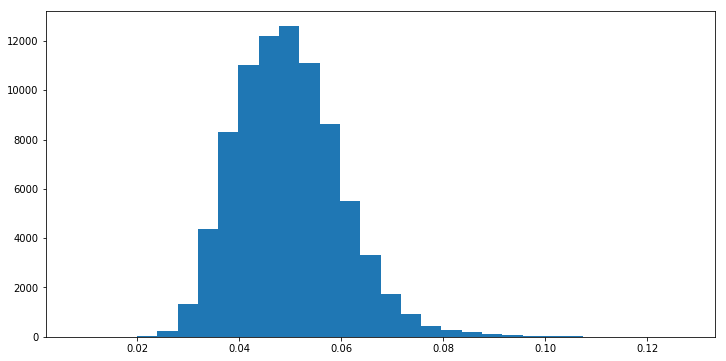

In [254]:
plt.hist(pred_simp, bins=30)
plt.show()

Histogram oczekiwanych wartości zgłoszonych incydentów wskazuje, że wartości wahają się od 0.02 do około 0.11 z wyraźną asymetrią prawostronną.

#### Gini

In [271]:
test_df['Prediction'] = pred_simp
DF_for_gini = test_df[['ClaimNb', 'Exposure', 'Prediction']]
print("Ważony Gini: ", round(weightedGini(DF_for_gini),4)) #0.123

Ważony Gini:  0.1232


Ten najprostrzy model uzyskał wskaźnik ważony ginni na poziomie 0.123. 

### 4.2 regresja Poissona z wybranymi zmiennymi

Drugim etapem tworzenia modelu, jest usunięcie wybranych zmiennych. Szczególnie usunięcie po jednej zmiennej z każdej kategorii (paliwo, marka, region), aby uniknąć współliniowości zmiennych oraz usunięcie nieistotnych zmiennych o mocy silnika.

In [262]:
# Reset zbioru
df = pd.read_csv('MTPLfreq.csv')
df.set_index('PolicyID', inplace = True)
df.loc[df.Brand=='Renault, Nissan or Citroen', 'Brand'] = 'A'
df.loc[df.Brand=='Volkswagen, Audi, Skoda or Seat', 'Brand'] = 'B'
df.loc[df.Brand=='Opel, General Motors or Ford', 'Brand'] = 'C'
df.loc[df.Brand=='Fiat', 'Brand'] = 'D'
df.loc[df.Brand=='Mercedes, Chrysler or BMW', 'Brand'] = 'E'
df.loc[df.Brand=='Japanese (except Nissan) or Korean', 'Brand'] = 'F'
df.loc[df.Brand=='other', 'Brand'] = 'G'
train_df = df.loc[(df.index.map(lambda x: str(x)[-1:])!='8') & (df.index.map(lambda x: str(x)[-1:])!='9'),]
test_df = df.loc[(df.index.map(lambda x: str(x)[-1:])=='8') | (df.index.map(lambda x: str(x)[-1:])=='9'),]
del df
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

In [263]:
# Usuwanie niepotrzebnych zmiennch
#train_df = train_df.drop(["Gas_Regular", "Region_R53", "Power_d", "Power_e","Power_f", "Power_g", "Power_h", "Power_i",  "Power_j", "Power_k", "Power_l", "Power_m", "Power_n", "Power_o", "Brand_C"], axis= 1)
#test_df = test_df.drop(["Gas_Regular", "Region_R53", "Power_d", "Power_e","Power_f", "Power_g", "Power_h", "Power_i",  "Power_j", "Power_k", "Power_l", "Power_m", "Power_n", "Power_o", "Brand_C"], axis = 1)

# pozostawione l,d, f, n
train_df = train_df.drop(["Gas_Regular", "Region_R25", "Region_R24", "Region_R31", "Region_R52", "Region_R72",
                          "Power_e", "Power_f", "Power_g", "Power_h", "Power_i",  "Power_j", "Power_k", "Power_l", "Power_m", "Power_o", 
                          "Brand_A", "Brand_B", "Brand_D", "Brand_E", "Brand_G"], axis= 1)
test_df = test_df.drop(["Gas_Regular", "Region_R25", "Region_R24", "Region_R31", "Region_R52", "Region_R72",
                          "Power_e", "Power_f", "Power_g", "Power_h", "Power_i",  "Power_j", "Power_k", "Power_l","Power_m", "Power_o", 
                          "Brand_A", "Brand_B", "Brand_D", "Brand_E", "Brand_G"], axis= 1)

In [264]:
formula = "ClaimNb ~ "
for col in train_df.columns:
    if col != 'ClaimNb' and col != 'Exposure' and col != 'PolicyID':
        if formula != "ClaimNb ~ ":
            formula = formula + "+" + col
        else:
            formula = "ClaimNb ~ " + str(col)
formula

'ClaimNb ~ CarAge+DriverAge+Density+Power_d+Power_n+Brand_C+Brand_F+Gas_Diesel+Region_R11+Region_R23+Region_R53+Region_R54+Region_R74'

In [265]:
poisson_reg = smf.glm(str(formula), train_df, family=sm.families.Poisson(), freq_weights=train_df['Exposure']).fit()
poisson_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                ClaimNb   No. Observations:               330535
Model:                            GLM   Df Residuals:                   185445
Model Family:                 Poisson   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36913.
Date:                Mon, 04 Feb 2019   Deviance:                       56064.
Time:                        17:57:07   Pearson chi2:                 1.94e+05
No. Iterations:                     7   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.7317      0.046    -60.025      0.000      -2.821      -2.642
CarAge        -0.0182      0.002     -8.675      0.000      -0.022      -0.014
DriverAge     -0.0037      0.001     -5.079      0.000      -0.005      -0.002
Density     1.517e-05   2.65e-06      5.730      0.000    9.98e-06    2.04e-05
Power_d       -0.1059      0.031     -3.423      0.001      -0.166      -0.045
Power_n        0.2640      0.173      1.523      0.128      -0.076       0.604
Brand_C        0.1124      0.034      3.316      0.001       0.046       0.179
Brand_F       -0.4070      0.038    -10.787      0.000      -0.481      -0.333
Gas_Diesel     0.0864      0.022      3.902      0.000       0.043       0.130
Region_R11     0.1020      0.040      2.542      0.011       0.023       0.181
Region_R23    -0.1380      0.098     -1.403      0.161      -0.331       0.055
Region_R53     0.0540      0.032      1.674      0.094      -0.009       0.117
Region_R54     0.0575      0.049      1.174      0.240      -0.038       0.153
Region_R74     0.2728      0.095      2.881      0.004       0.087       0.458
==============================================================================
"""

Wszystkie zmienne są istotne (przy poziomie ufności 75%).

Współczynniki potwierdzają tezę o pozytywnej zależności liczby zgłoszeń i gęstości zaludnienia oraz negatywnej zależności wieku samochodu oraz wieku kierowcy z ilością zgłoszeń. Czyli im starszy samochód i im starszy kierowca, tym mniej zgłoszeń. Dodatkowo sprawdza się, że Japońskie samochody (marka F) mają mniej zgłoszeń, w przeciwieństwie do Opli, GM i Fordów.
Generalnie wyniki są zgodne z tym, co wydawało się już na etapie "data exploration".

In [266]:
pred = poisson_reg.predict(test_df.drop(['ClaimNb', 'Exposure'], axis=1))

In [269]:
test_df['Prediction'] = pred
DF_for_gini = test_df[['ClaimNb', 'Exposure', 'Prediction']]
print("Ważony Gini: ", round(weightedGini(DF_for_gini),4)) #0.123

Ważony Gini:  0.1144


Po usunięciu zmiennych o mocy silnika Gini nieznacznie wzrósł (z .12321 do .12331) może to świadczyć o tym, że poprzedni model był przeuczony. Niestety kilka zmiennych opisujących region było nadal nieistotnych. Po usunięciu kilku dodatkowych niepotrzebnych zmiennch Gini spadł do 0.114, ale wszystkie zmienne pozostały istotne.

## 5. regresja Poissona + splajny

W tym modelu podzielę zmienne ilościowe "DriverAge" i "CarAge" arbitralnie na maksymalnie 20 koszyków, a zmienną Density na 50. Dzięki temu każdy koszyk będzie zmienną binarną. Nie jest to najlepszy sposób, ponieważ predykcja nie będzie oparta o funkcję ciągłą, ale teoretczynie powinno się udać choć trochę uchwycić nielinowość zmiennch, a duża liczba koszyków zrekompensuje po części brak ciągłości. W zbiorze treningowym jest 330 tyś. obserwacji, więc nie trzeba się przejmować malejącą liczbą stopni swobody.

Gdybym miał więcej czasu postarałbym się wykorzystać wielomiany, by zapewnić ciągłość.

In [402]:
# Reset zbioru
df = pd.read_csv('MTPLfreq.csv')
df.set_index('PolicyID', inplace = True)
df.loc[df.Brand=='Renault, Nissan or Citroen', 'Brand'] = 'A'
df.loc[df.Brand=='Volkswagen, Audi, Skoda or Seat', 'Brand'] = 'B'
df.loc[df.Brand=='Opel, General Motors or Ford', 'Brand'] = 'C'
df.loc[df.Brand=='Fiat', 'Brand'] = 'D'
df.loc[df.Brand=='Mercedes, Chrysler or BMW', 'Brand'] = 'E'
df.loc[df.Brand=='Japanese (except Nissan) or Korean', 'Brand'] = 'F'
df.loc[df.Brand=='other', 'Brand'] = 'G'

In [403]:
train_df = df.loc[(df.index.map(lambda x: str(x)[-1:])!='8') & (df.index.map(lambda x: str(x)[-1:])!='9'),]
test_df = df.loc[(df.index.map(lambda x: str(x)[-1:])=='8') | (df.index.map(lambda x: str(x)[-1:])=='9'),]
del df
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

In [404]:
bins_driver = np.unique(train_df["DriverAge"].quantile(np.linspace(0.05,1,20)))
bins_car = np.unique(train_df["CarAge"].quantile(np.linspace(0.05,1,20)))
bins_dens = np.unique(train_df["Density"].quantile(np.linspace(0.05,1,51)))

In [405]:
# Podział wieku kierowcy
df_DriverAge, bins = pd.cut(train_df['DriverAge'], bins_driver, retbins=True, right=True)
df_DriverAge.value_counts(sort=False)
df_DriverAge = pd.DataFrame(df_DriverAge)
df_DriverAge['PolicyID'] = df_DriverAge.index.values
df_DriverAge_dummies = pd.get_dummies(df_DriverAge)
df_DriverAge_dummies.head()

# Podział wieku samochodu
df_CarAge, bins = pd.cut(train_df['CarAge'], bins_car, retbins=True, right=True)
df_CarAge.value_counts(sort=False)
df_CarAge = pd.DataFrame(df_CarAge)
df_CarAge['PolicyID'] = df_CarAge.index.values
df_CarAge_dummies = pd.get_dummies(df_CarAge)
df_CarAge_dummies.head()

# Podział gęstości zaludnienia
df_Density, bins = pd.cut(train_df['Density'], bins_dens, retbins=True, right=True)
df_Density.value_counts(sort=False)
df_Density = pd.DataFrame(df_Density)
df_Density['PolicyID'] = df_Density.index.values
df_Density_dummies = pd.get_dummies(df_Density)
df_Density_dummies.head()

train_df = train_df.drop(['DriverAge', 'CarAge', 'Density'], axis=1)
train_df = train_df.join(df_DriverAge_dummies, how='outer')
train_df = pd.merge(train_df, df_CarAge_dummies, how='inner')
train_df = pd.merge(train_df, df_Density_dummies, how='inner', on='PolicyID')

del df_CarAge, df_CarAge_dummies, df_DriverAge, df_DriverAge_dummies, bins, df_Density, df_Density_dummies

# Modyfikacja nazwy
for col in train_df.columns:
    train_df.rename(columns={col: col.replace("]", "").replace(" ", "").replace("-", "").replace(".", "").replace(",", "").replace(")", "").replace("[", "").replace("(", "").replace("(", "").replace("]", "")}, inplace=True)
    
# To samo dla zbioru testowego
df_DriverAge, bins = pd.cut(test_df['DriverAge'], bins_driver, retbins=True, right=True)
df_DriverAge.value_counts(sort=False)
df_DriverAge = pd.DataFrame(df_DriverAge)
df_DriverAge['PolicyID'] = df_DriverAge.index.values
df_DriverAge_dummies = pd.get_dummies(df_DriverAge)
df_DriverAge_dummies.head()

df_CarAge, bins = pd.cut(test_df['CarAge'],  bins_car, retbins=True, right=True)
df_CarAge.value_counts(sort=False)
df_CarAge = pd.DataFrame(df_CarAge)
df_CarAge['PolicyID'] = df_CarAge.index.values
df_CarAge_dummies = pd.get_dummies(df_CarAge)
df_CarAge_dummies.head()

# Podział gęstości zaludnienia
df_Density, bins = pd.cut(test_df['Density'], bins_dens, retbins=True, right=True)
df_Density.value_counts(sort=False)
df_Density = pd.DataFrame(df_Density)
df_Density['PolicyID'] = df_Density.index.values
df_Density_dummies = pd.get_dummies(df_Density)
df_Density_dummies.head()

test_df = test_df.drop(['DriverAge', 'CarAge', 'Density'], axis=1)
test_df = test_df.join(df_DriverAge_dummies, how='outer')
test_df = pd.merge(test_df, df_CarAge_dummies, how='inner')
test_df = pd.merge(test_df, df_Density_dummies, how='inner', on='PolicyID')

del df_CarAge, df_CarAge_dummies, df_DriverAge, df_DriverAge_dummies, bins, df_Density, df_Density_dummies


for col in test_df.columns:
    test_df.rename(columns={col: col.replace("]", "").replace(" ", "").replace("-", "").replace(".", "").replace(",", "").replace(")", "").replace("[", "").replace("(", "").replace("(", "").replace("]", "")}, inplace=True)  

C:\Users\adamw\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2910: FutureWarning: 'PolicyID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\adamw\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2910: FutureWarning: 'PolicyID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [406]:
# Usunięte wszystkie poziomy mocy
#train_df = train_df.drop(["Gas_Regular", "Region_R53", "Power_d", "Power_e","Power_f", "Power_g", "Power_h", "Power_i",  "Power_j", "Power_k", "Power_l", "Power_m", "Power_n", "Power_o", "Brand_C"], axis= 1)
#test_df = test_df.drop(["Gas_Regular", "Region_R53", "Power_d", "Power_e","Power_f", "Power_g", "Power_h", "Power_i",  "Power_j", "Power_k", "Power_l", "Power_m", "Power_n", "Power_o", "Brand_C"], axis = 1)

# pozostawione l,d, f, n
train_df = train_df.drop(["Gas_Regular", "Region_R74",
                          "Power_e", "Power_h", "Power_i",  "Power_k", "Power_l", "Power_m", "Power_o", 
                          "Brand_G", "Brand_D", "Brand_E", "Brand_B"], axis= 1)
test_df = test_df.drop(["Gas_Regular", "Region_R74",
                          "Power_e", "Power_h", "Power_i",  "Power_k", "Power_l", "Power_m", "Power_o", 
                          "Brand_G", "Brand_D", "Brand_E", "Brand_B"], axis= 1)

In [407]:
formula = "ClaimNb ~ "
for col in train_df.columns:
    if col != 'ClaimNb' and col != 'Exposure' and col != 'PolicyID':
        if formula != "ClaimNb ~ ":
            formula = formula + "+" + col
        else:
            formula = "ClaimNb ~ " + str(col)
formula

'ClaimNb ~ Power_d+Power_f+Power_g+Power_j+Power_n+Brand_A+Brand_C+Brand_F+Gas_Diesel+Region_R11+Region_R23+Region_R24+Region_R25+Region_R31+Region_R52+Region_R53+Region_R54+Region_R72+DriverAge_250280+DriverAge_280300+DriverAge_300320+DriverAge_320340+DriverAge_340360+DriverAge_360380+DriverAge_380400+DriverAge_400420+DriverAge_420440+DriverAge_440460+DriverAge_460480+DriverAge_480500+DriverAge_500520+DriverAge_520540+DriverAge_540570+DriverAge_570610+DriverAge_610660+DriverAge_660720+DriverAge_720990+CarAge_0010+CarAge_1020+CarAge_2030+CarAge_3040+CarAge_4050+CarAge_5060+CarAge_6070+CarAge_7080+CarAge_8090+CarAge_90100+CarAge_100110+CarAge_110120+CarAge_120130+CarAge_130140+CarAge_140150+CarAge_150170+CarAge_1701000+Density_170220+Density_220260+Density_260290+Density_290330+Density_330390+Density_390440+Density_440480+Density_480520+Density_520570+Density_570640+Density_640720+Density_720820+Density_820910+Density_910980+Density_9801080+Density_10801200+Density_12001330+Density_1330

In [408]:
poisson_reg = smf.glm(str(formula), train_df, family=sm.families.Poisson(), freq_weights=train_df['Exposure']).fit()
poisson_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                ClaimNb   No. Observations:               330535
Model:                            GLM   Df Residuals:                   185355
Model Family:                 Poisson   Df Model:                          103
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36673.
Date:                Mon, 04 Feb 2019   Deviance:                       55583.
Time:                        19:00:12   Pearson chi2:                 1.93e+05
No. Iterations:                     7   Covariance Type:             nonrobust
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.7248      0.133    -20.552      0.000      -2.985      -2.465
Power_d                 -0.1356      0.034     -4.009      0.000      -0.202      -0.069
Power_f                 -0.0380      0.028     -1.350      0.177      -0.093       0.017
Power_g                 -0.0560      0.029     -1.938      0.053      -0.113       0.001
Power_j                  0.0703      0.054      1.294      0.196      -0.036       0.177
Power_n                  0.2342      0.174      1.344      0.179      -0.107       0.576
Brand_A                 -0.0500      0.027     -1.840      0.066      -0.103       0.003
Brand_C                  0.0430      0.039      1.100      0.271      -0.034       0.120
Brand_F                 -0.3902      0.043     -8.988      0.000      -0.475      -0.305
Gas_Diesel               0.1287      0.023      5.669      0.000       0.084       0.173
Region_R11              -0.3237      0.106     -3.064      0.002      -0.531      -0.117
Region_R23              -0.5423      0.138     -3.920      0.000      -0.813      -0.271
Region_R24              -0.3916      0.098     -3.997      0.000      -0.584      -0.200
Region_R25              -0.3571      0.115     -3.108      0.002      -0.582      -0.132
Region_R31              -0.3756      0.108     -3.483      0.000      -0.587      -0.164
Region_R52              -0.3796      0.103     -3.687      0.000      -0.581      -0.178
Region_R53              -0.3916      0.103     -3.817      0.000      -0.593      -0.191
Region_R54              -0.3359      0.108     -3.096      0.002      -0.549      -0.123
Region_R72              -0.3822      0.107     -3.580      0.000      -0.591      -0.173
DriverAge_250280        -0.4307      0.061     -7.010      0.000      -0.551      -0.310
DriverAge_280300        -0.5166      0.066     -7.839      0.000      -0.646      -0.387
DriverAge_300320        -0.5779      0.065     -8.863      0.000      -0.706      -0.450
DriverAge_320340        -0.5663      0.064     -8.876      0.000      -0.691      -0.441
DriverAge_340360        -0.5749      0.064     -9.037      0.000      -0.700      -0.450
DriverAge_360380        -0.5148      0.062     -8.344      0.000      -0.636      -0.394
DriverAge_380400        -0.5281      0.062     -8.486      0.000      -0.650      -0.406
DriverAge_400420        -0.4597      0.061     -7.529      0.000      -0.579      -0.340
DriverAge_420440        -0.3690      0.060     -6.191      0.000      -0.486      -0.252
DriverAge_440460        -0.4215      0.061     -6.953      0.000      -0.540      -0.303
DriverAge_460480        -0.4013      0.060     -6.707      0.000      -0.519      -0.284
DriverAge_480500        -0.3762      0.058     -6.442      0.000      -0.491      -0.262
DriverAge_500520        -0.4065      0.058     -6.957      0.000      -0.521      -0.292
DriverAge_520540        -0.4697      0.061     

In [409]:
pred = poisson_reg.predict(test_df.drop(['ClaimNb', 'Exposure'], axis=1))

#### Gini

In [412]:
test_df['Prediction'] = pred
DF_for_gini = test_df[['ClaimNb', 'Exposure', 'Prediction']]
print("Ważony Gini: " , round(weightedGini(DF_for_gini), 4))

Ważony Gini:  0.1793


Dzięki podziale zmiennych ilościowych na koszyki udało się zwiększyc współczynnik Giniego do .1793, co jest relatywnie dużą poprawą wobec zwykłego modelu.

## 6. Gradient Boosting Model

Nie znałem tego modelu wcześniej. Opierałem się materiałami znalezionymi w internecie.

Źródło: <br>
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

In [4]:
from sklearn.ensemble import GradientBoostingRegressor  #GBM algorithm

In [5]:
# Reset zbioru
df = pd.read_csv('MTPLfreq.csv')
df.set_index('PolicyID', inplace = True)
df.loc[df.Brand=='Renault, Nissan or Citroen', 'Brand'] = 'A'
df.loc[df.Brand=='Volkswagen, Audi, Skoda or Seat', 'Brand'] = 'B'
df.loc[df.Brand=='Opel, General Motors or Ford', 'Brand'] = 'C'
df.loc[df.Brand=='Fiat', 'Brand'] = 'D'
df.loc[df.Brand=='Mercedes, Chrysler or BMW', 'Brand'] = 'E'
df.loc[df.Brand=='Japanese (except Nissan) or Korean', 'Brand'] = 'F'
df.loc[df.Brand=='other', 'Brand'] = 'G'
train_df = df.loc[(df.index.map(lambda x: str(x)[-1:])!='8') & (df.index.map(lambda x: str(x)[-1:])!='9'),]
test_df = df.loc[(df.index.map(lambda x: str(x)[-1:])=='8') | (df.index.map(lambda x: str(x)[-1:])=='9'),]
del df
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

In [6]:
train_df = train_df.drop(["Gas_Regular", "Region_R72",
                          "Power_o", 
                          "Brand_D"], axis= 1)
test_df = test_df.drop(["Gas_Regular", "Region_R72",
                          "Power_o", 
                          "Brand_D"], axis= 1)

In [7]:
# Wybierz wszystkie zmienne
predictors = train_df.drop(['ClaimNb', 'Exposure'], axis=1).columns

In [8]:
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}

In [ ]:
gbm0 = GradientBoostingRegressor(**params)
gbm_reg = gbm0.fit(train_df[predictors],train_df['ClaimNb'], sample_weight = train_df['Exposure'])

In [ ]:
pred_gbm = gbm_reg.predict(test_df[predictors])

In [ ]:
test_df['Prediction'] = pred_gbm
DF_for_gini = test_df[['ClaimNb', 'Exposure', 'Prediction']]
Print("Ważony Gini: ", weightedGini(DF_for_gini))

Dla powyższych parametrów (wziętych wprost z przykładu znalezionego w internecie) udało się otrzymać współczynnik Gini na poziomie .1795, co i tak jest wynikiem lepszym niż wszystkie modele, które przygotowałem powyżej. Gdybym miał więcej czasu, przeprowadziłbym kalibrację parametrów. 

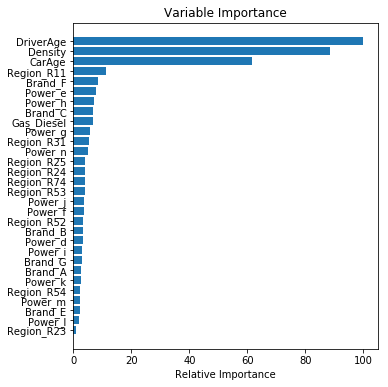

In [428]:
# Plot feature importance
feature_importance = gbm0.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, test_df[predictors].columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## 7. Podsumowanie

Model glm ze splajnami i gbm uzyskały podobne wartości współczynnika ważonego Gini (około 0.18). Oba jednak nie są jeszcze idealne. Żeby poprawić dopasowanie, w modelu ze splajnami należy wykorzystać wielomiany, natomiast model gbm dobrze by było porządnie skalibrować. Niestety kalibracja gbm wymaga przeliczenia modelu gbm wiele razy, a nawet jedna iteracja zajmuje dużo czasu, więc pozostawię model w takim formacie jak jest.